# Tree based methods

J. Renero<br>
January 2019

Trees construct prediction models from data. They recursively partition the data space to fit a boolean prediction model within each partition. The result is represented graphically as a decision tree. Trees can be used for regression of classification.

When the number of features, $p$, is large interpretability is easier than in distance based methods or probabilistic classification, where boundaries are much more difficult to be explained in higer dimensions.

For better visualizations of the trees, explore [dtreeviz](https://github.com/parrt/dtreeviz)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tree-based-methods" data-toc-modified-id="Tree-based-methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tree based methods</a></span><ul class="toc-item"><li><span><a href="#Regression-Example" data-toc-modified-id="Regression-Example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Regression Example</a></span><ul class="toc-item"><li><span><a href="#Load-the-data-and-split-the-dataset" data-toc-modified-id="Load-the-data-and-split-the-dataset-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Load the data and split the dataset</a></span></li><li><span><a href="#Fit-a-simple-regression-tree-(no-CV)" data-toc-modified-id="Fit-a-simple-regression-tree-(no-CV)-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Fit a simple regression tree (no CV)</a></span></li><li><span><a href="#Display-the-tree" data-toc-modified-id="Display-the-tree-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Display the tree</a></span></li><li><span><a href="#Variables-Importance" data-toc-modified-id="Variables-Importance-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Variables Importance</a></span></li><li><span><a href="#Evaluating-the-tree" data-toc-modified-id="Evaluating-the-tree-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Evaluating the tree</a></span></li></ul></li><li><span><a href="#Classification-Example" data-toc-modified-id="Classification-Example-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Classification Example</a></span><ul class="toc-item"><li><span><a href="#Display-the-tree" data-toc-modified-id="Display-the-tree-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Display the tree</a></span></li><li><span><a href="#Variables-importance" data-toc-modified-id="Variables-importance-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Variables importance</a></span></li><li><span><a href="#Evaluating-the-tree" data-toc-modified-id="Evaluating-the-tree-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluating the tree</a></span></li><li><span><a href="#Cross-Validation-and-Grid-search" data-toc-modified-id="Cross-Validation-and-Grid-search-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Cross Validation and Grid search</a></span></li><li><span><a href="#Working-with-the-probabilities-of-the-estimations" data-toc-modified-id="Working-with-the-probabilities-of-the-estimations-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Working with the probabilities of the estimations</a></span></li></ul></li><li><span><a href="#Optimization-techniques" data-toc-modified-id="Optimization-techniques-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Optimization techniques</a></span><ul class="toc-item"><li><span><a href="#Bagging" data-toc-modified-id="Bagging-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Bagging</a></span></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Boosting" data-toc-modified-id="Boosting-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Boosting</a></span></li></ul></li></ul></li></ul></div>

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import graphviz
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  
from sklearn import tree
from sklearn.exceptions import DataConversionWarning
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.validation import column_or_1d


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
    
%matplotlib inline

## Regression Example

We will start by building a simple regression example with the [wholesale customer dataset in UCI](https://archive.ics.uci.edu/ml/datasets/wholesale+customers). It contains 440 samples of 8 variables, and we will try to build a model that will help us to predict the annual spending on fresh products (first variable) with a regression tree.

### Load the data and split the dataset

In [2]:
class Split:
    """
    This class represents a split from a dataset, it will assign
    each dataframe partition passed as argument to a different 
    attribute of the class: 'train', 'test' (and 'validation').
    The class method 'split' performs the splitting of the dataframe
    passed, according to the parameters passed.
    
    Example:
    
        X, Y = Split.split(my_data, my_target)
        
    """
    split_name = ['train', 'test', 'validation']
    
    def __init__(self, splits):
        for index, partition in enumerate(splits):
            setattr(self, self.split_name[index], partition)

    @classmethod
    def split(cls,
              data, 
              target, 
              seed=1024, 
              test_size=0.2, 
              validation_split=False):
        """
        From an input dataframe, separate features from target, and 
        produce splits (with or without validation).
        """
        features = list(data)
        features.remove(target)
        X = pd.DataFrame(data, columns=features)
        Y = pd.DataFrame(data.loc[:, target])

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, 
            test_size=test_size, random_state=seed)

        if validation_split is True:
            X_train, X_val, Y_train, Y_val = train_test_split(
                X_train, Y_train, 
                test_size=test_size, random_state=seed)
            X_splits = [X_train, X_test, X_val]
            Y_splits = [Y_train, Y_test, Y_val]
        else:
            X_splits = [X_train, X_test]
            Y_splits = [Y_train, Y_test]

        return Split(X_splits), Split(Y_splits)

In [3]:
class Dataset:
    """
    This class allows a simpler representation of the dataset used
    to build a model in class. It allows loading a remote CSV by
    providing an URL to the initialization method of the object.

        my_data = Dataset(URL)
        
    """
    def __init__(self, data_location):
        self.data = pd.read_csv(data_location)
        
    def target(self, target):
        self.features = list(self.data)
        self.features.remove(target)
        self.target = target

In [4]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
wholesale = Dataset(data_url)
wholesale.target('Fresh')
X, Y = Split.split(wholesale.data, wholesale.target)

### Fit a simple regression tree (no CV)

In [5]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=3)
regressor.fit(X.train, Y.train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

### Display the tree

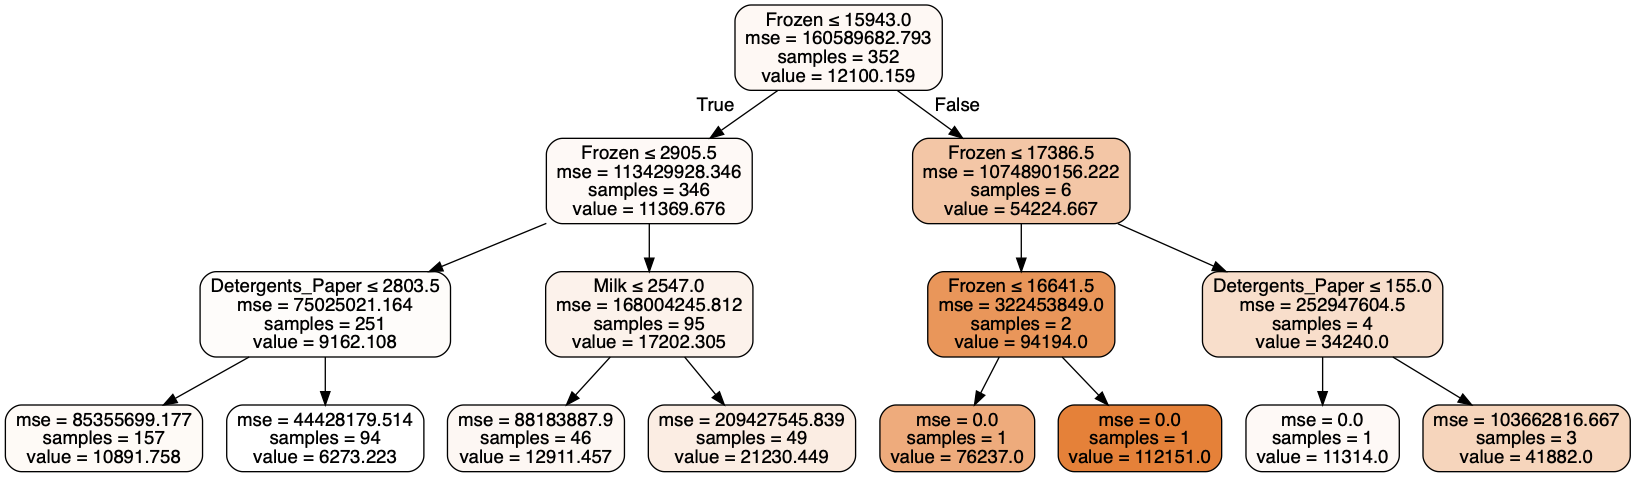

In [6]:
def display_tree(tree, features):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,
                    feature_names=features,
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    image = Image(graph.create_png())
    display(image)
    
display_tree(regressor, wholesale.features)

### Variables Importance

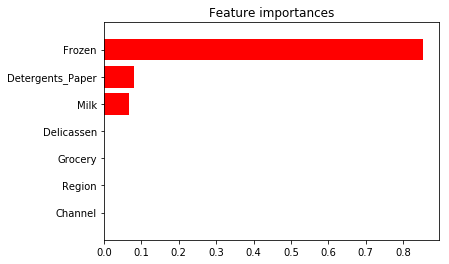

In [7]:
def features_importance(tree, X):
    """
    Plot the variables importance from the fitted tree and the 
    training dataset used.
    """
    importances = tree.feature_importances_
    indices = np.argsort(importances)

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(X.train.shape[1]), importances[indices],
           color="r", align="center")

    index_names = [list(X.train)[i] for i in indices]

    plt.yticks(range(X.train.shape[1]), index_names)
    plt.ylim([-1, X.train.shape[1]])
    plt.show()

features_importance(regressor, X)

Understanding the tree structure (partially from [here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py))

In [8]:
def explain_tree(regressor):
    n_nodes = regressor.tree_.node_count
    children_left = regressor.tree_.children_left
    children_right = regressor.tree_.children_right
    feature = regressor.tree_.feature
    threshold = regressor.tree_.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))

explain_tree(regressor)

The binary tree structure has 15 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 4] <= 15943.0 else to node 8.
	node=1 test node: go to node 2 if X[:, 4] <= 2905.5 else to node 5.
		node=2 test node: go to node 3 if X[:, 5] <= 2803.5 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: go to node 6 if X[:, 2] <= 2547.0 else to node 7.
			node=6 leaf node.
			node=7 leaf node.
	node=8 test node: go to node 9 if X[:, 4] <= 17386.5 else to node 12.
		node=9 test node: go to node 10 if X[:, 4] <= 16641.5 else to node 11.
			node=10 leaf node.
			node=11 leaf node.
		node=12 test node: go to node 13 if X[:, 5] <= 155.0 else to node 14.
			node=13 leaf node.
			node=14 leaf node.


### Evaluating the tree

What's the $R^2$ of this tree when making predictions? The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

In [9]:
def evaluate_regressor(tree, X, Y):
    """
    Evaluates a tree with the data values passed, returning the R2 and MSE
    """
    r2 = tree.score(X, Y)
    e = tree.predict(X)
    mse = np.average(np.power((e - Y.values), 2))
    return r2, mse

r2, mse = evaluate_regressor(regressor, X.test, Y.test)
print('The R2 of the regressor is: {:.4f}'.format(r2))
print('The MSE is: {:.4f}'.format(mse))

The R2 of the regressor is: -0.8044
The MSE is: 314539617.0210


If we evaluate the regressor with the function just described above, for a range of trees where the maximum depth ranges from 3 to 20, what we can see is the result oscilates a little bit but they're not specially good. The performance of a regression tree in this problem is specially bad. **Trees are not very good for regression problems** with features in a continuous space.

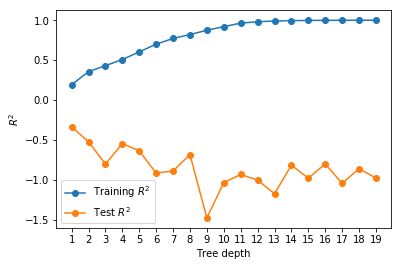

In [10]:
# Plot the $R^2$ values obtained when varying the depth of the tree
min_depth = 1
max_depth = 20
r2s_train = []
r2s_test = []
for i in range(min_depth, max_depth):
    tree = DecisionTreeRegressor(random_state=0, max_depth=i).fit(X.train, Y.train)
    r2, _ = evaluate_regressor(tree, X.train, Y.train)
    r2s_train.append(r2)
    r2, _ = evaluate_regressor(tree, X.test, Y.test)
    r2s_test.append(r2)
    del(tree)
    
plt.plot(r2s_train, 'o-', label='Training $R^2$')
plt.plot(r2s_test, 'o-', label='Test $R^2$')
plt.xticks(range(min_depth-1, max_depth-1), ['{}'.format(i) for i in range(min_depth, max_depth)])
plt.xlabel('Tree depth')
plt.ylabel('$R^2$')
plt.legend()
plt.show()

## Classification Example

Let's build, using the same dataset a classification case. To do so the goal of this new model will be predicting the channel used by the customer (1 or 2), so we have a **binomial** classification problem.

In [11]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
wholesale = Dataset(data_url)
wholesale.target('Channel')

X, Y = Split.split(wholesale.data, wholesale.target)

classifier = DecisionTreeClassifier(random_state=0, max_depth=3)
classifier.fit(X.train, Y.train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

### Display the tree

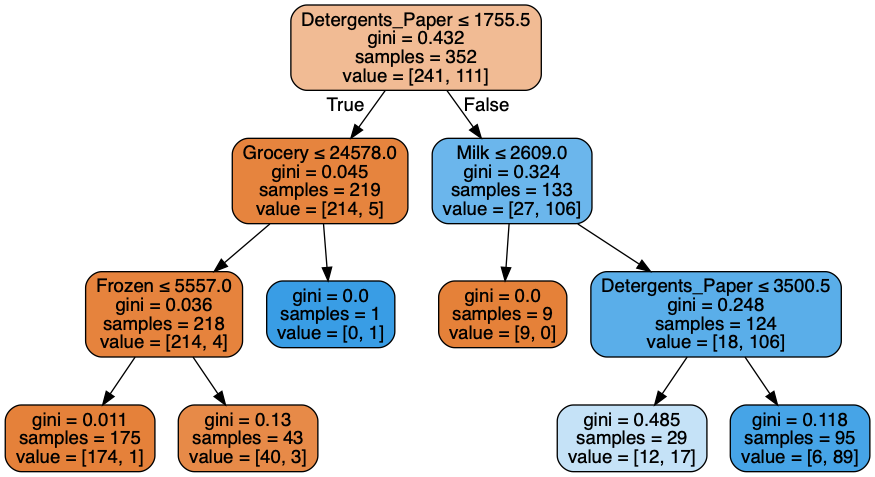

In [12]:
display_tree(classifier, wholesale.features)

In [13]:
explain_tree(classifier)

The binary tree structure has 11 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 5] <= 1755.5 else to node 6.
	node=1 test node: go to node 2 if X[:, 3] <= 24578.0 else to node 5.
		node=2 test node: go to node 3 if X[:, 4] <= 5557.0 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 leaf node.
	node=6 test node: go to node 7 if X[:, 2] <= 2609.0 else to node 8.
		node=7 leaf node.
		node=8 test node: go to node 9 if X[:, 5] <= 3500.5 else to node 10.
			node=9 leaf node.
			node=10 leaf node.


### Variables importance

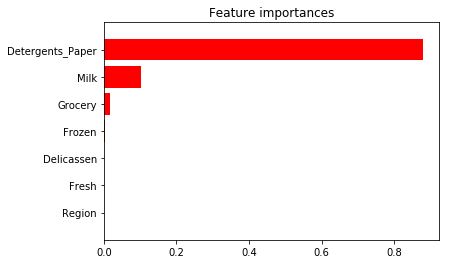

In [14]:
features_importance(classifier, X)

### Evaluating the tree

This case, the evaluation metric is the GINI index.

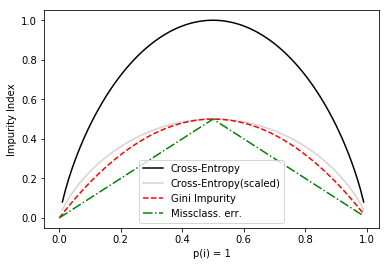

In [15]:
# Plot the Entropy, Gini Index and missclassification error curves
def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1 - p))

def cross_entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)
ent = [cross_entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                        ['Cross-Entropy','Cross-Entropy(scaled)',
                        'Gini Impurity', 'Missclass. err.'],
                        ['-','-','--','-.'],
                        ['black','lightgrey','red','green','cyan']):
    line = plt.plot(x, i, label=lab, linestyle=ls, color=c)
plt.legend(loc='best')
plt.xlabel('p(i) = 1')
plt.ylabel('Impurity Index')
plt.show()

In [16]:
def evaluate_classifier(tree, X, Y):
    """
    Evaluates a tree with the data values passed, returning the R2 and MSE
    """
    miss_rate = tree.score(X, Y)
    return miss_rate

miss_rate = evaluate_classifier(classifier, X.test, Y.test)
print('The missclassification error rate is: {:.4f}'.format(miss_rate))

The missclassification error rate is: 0.9091


We can see that if we vary the depth of the tree from 3 up to 19, the trend is that the error rate grows.... which sounds counterintuitive, as we're making our tree better and better. The explanation is very easy: we're overfitting. Trees are prone to increase variance, and thus produce a worse generalization.

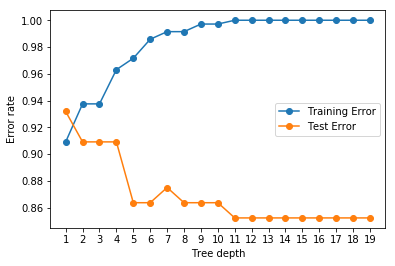

In [17]:
# Plot the $R^2$ values obtained when varying the depth of the tree
min_depth = 1
max_depth = 20
mers_train = []
mers_test = []
for i in range(min_depth, max_depth):
    tree = DecisionTreeClassifier(random_state=0, max_depth=i).fit(X.train, Y.train)
    mer = evaluate_classifier(tree, X.train, Y.train)
    mers_train.append(mer)
    mer = evaluate_classifier(tree, X.test, Y.test)
    mers_test.append(mer)
    del(tree)
    
plt.plot(mers_train, 'o-', label='Training Error')
plt.plot(mers_test, 'o-', label='Test Error')
plt.xticks(range(min_depth-1, max_depth-1), ['{}'.format(i) for i in range(min_depth, max_depth)])
plt.xlabel('Tree depth')
plt.ylabel('Error rate')
plt.legend()
plt.show()

### Cross Validation and Grid search

Now, we will use cross validation to check what is the average score when using different splits. To do so, instead of fitting a single split, we will use the method `cross_val_score` with `cv` param set to 10 (you can try different ones). For each value of the depth we're trying, an average accuracy will be produced over different splits, using _k_fold_ scheme, with $k = 10$.

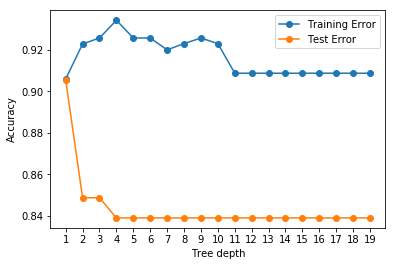

In [18]:
# Plot the accuracy values obtained when varying the depth of the tree
min_depth = 1
max_depth = 20
mers_train = []
mers_test = []
for i in range(min_depth, max_depth):
    tree = DecisionTreeClassifier(random_state=0, max_depth=i).fit(X.train, Y.train)
    mer = cross_val_score(tree, X.train, Y.train, cv=10)
    mers_train.append(np.mean(mer))
    mer = cross_val_score(tree, X.test, Y.test, cv=10)
    mers_test.append(np.mean(mer))
    del(tree)
    
plt.plot(mers_train, 'o-', label='Training Error')
plt.plot(mers_test, 'o-', label='Test Error')
plt.xticks(range(min_depth-1, max_depth-1), ['{}'.format(i) for i in range(min_depth, max_depth)])
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

What is the optimal depth for this tree given the results obtained with CV? Instead of looking at a plot, we can use the grid search over the parameters we want to try, and for the range of values we decide. The result is a much simpler approach to the problem where you don't have to write the loop, and a single call does all the job for you.

In [19]:
parameters = {'max_depth':range(min_depth, max_depth)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
clf.fit(X.train, Y.train)
best_tree = clf.best_estimator_
print('Optimal accuracy: {:.2f}, for max_depth={}'.format(
    clf.best_score_, clf.best_params_['max_depth']))

Optimal accuracy: 0.93, for max_depth=5


What is the score, for the TEST set, of that optimal tree? Let's use `cross_val_score` again to check it over the test set, using the best model from the previous step.

In [20]:
test_scores = cross_val_score(best_tree, X.test, Y.test, cv=5)
print('Average test score for 4-deep tree: {:.2f}'.format(
    np.mean(test_scores)))

Average test score for 4-deep tree: 0.83


### Working with the probabilities of the estimations

The predicted class probability is the fraction of samples of the same class in a leaf. We can apply __laplace smoothing__ or play with the __threshold__ to be applied to consider when to assign a leaf to each class to find better results than those obtained with the default 0.5 probability.

In the code below, we obetain the prediction probabilities for the 23rd sample in the test set.

In [21]:
sample = X.test.iloc[23, :].values.reshape(1, -1)
leaf_id = classifier.apply(sample)

print('Leaf node ID: ', leaf_id)
print('Decision path:\n', classifier.decision_path(sample), sep='')
print('Probabilities:', classifier.predict_proba(sample))
print('Number of samples of leaf node:', classifier.tree_.n_node_samples[leaf_id])
print('Impurity (Gini) of leaf node:', classifier.tree_.impurity[leaf_id])
print('Samples from each class:', classifier.tree_.value[leaf_id])

Leaf node ID:  [9]
Decision path:
  (0, 0)	1
  (0, 6)	1
  (0, 8)	1
  (0, 9)	1
Probabilities: [[0.4137931 0.5862069]]
Number of samples of leaf node: [29]
Impurity (Gini) of leaf node: [0.48513674]
Samples from each class: [[[12. 17.]]]


## Optimization techniques

### Bagging

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

We're producing `cv` splits, and for each of them we're growing 100 trees, each with a bootstrapped sample of the training set, to produce a classification, based on voting (hard or soft).

In [22]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=4), 
                            n_estimators=100,
                            max_samples=0.5, 
                            max_features=len(wholesale.features),
                            oob_score=True,
                            random_state=0, n_jobs=-1)
bagging.fit(X.train, column_or_1d(Y.train))
bagging_scores = cross_val_score(bagging, X.test, column_or_1d(Y.test), cv=10)
avg_score = np.mean(bagging_scores)
print(avg_score)

0.9180555555555555


The result {{ avg_score }} is much better than the one obtained by simply applying grid search over the max_depth parameters with cross-validation.

### Random Forests

Now, we're not only going to pick subsets of the training set to train a number of trees, but also to select subset of features. In the end, the classification will be performed by the avearege prediction made by the grown trees.

In [23]:
rf = RandomForestClassifier(n_estimators=100,
                            max_features=3,
                            max_depth=4,
                            oob_score=True,
                            random_state=0, n_jobs=-1)
rf.fit(X.train, column_or_1d(Y.train))
rf_scores = cross_val_score(rf, X.test, column_or_1d(Y.test), cv=10)
avg_score = np.mean(rf_scores)
print(avg_score)

0.8944444444444445


The result {{ avg_score }} is much better than the one obtained by simply applying grid search over the max_depth parameters with cross-validation, but slightly worse than in the bagging case.

### Boosting

Gradient Tree Boosting or Gradient Boosted Trees (GBT) is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

In [31]:
gb = GradientBoostingClassifier(n_estimators=100, 
                                learning_rate=1.0,
                                max_features=3,
                                max_depth=4, 
                                random_state=0)
gb.fit(X.train, column_or_1d(Y.train))
gb_scores = cross_val_score(gb, X.test, column_or_1d(Y.test), cv=10)
avg_score = np.mean(gb_scores)
print(avg_score)

0.8819444444444444


In [32]:
gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=4,
              max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

How to perform gridsearch or hyper parameter tuning over Gradient Boosting trees?


In [35]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.1, 0.25, 0.5, 1.0],
    "min_samples_split": np.linspace(0.1, 0.5, 5),
    "min_samples_leaf": np.linspace(0.1, 0.5, 5),
    "max_depth":[2, 3, 4],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[10]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)
# Grid search takes 10 or more minutes, so I disable it.
# clf.fit(X.train, column_or_1d(Y.train))  

print(clf.score(X.train, column_or_1d(Y.train)))
print(clf.best_params_)

0.9517045454545454
{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'n_estimators': 10, 'subsample': 1.0}


In [37]:
hpgb_scores = cross_val_score(clf.best_estimator_, X.test, column_or_1d(Y.test), cv=10)
avg_score = np.mean(hpgb_scores)
print(avg_score)

0.8722222222222221


Parameters found are

    'criterion': 'friedman_mse', 
    'learning_rate': 0.5, 
    'loss': 'deviance', 
    'max_depth': 2, 
    'max_features': 'log2', 
    'min_samples_leaf': 0.2, 
    'min_samples_split': 0.2, 
    'n_estimators': 10, 
    'subsample': 1.0

Surprisingly, for this particular problem and this dataset, we're not getting better results ({{avg_score}}) with GBoost, or we couldn't find the proper set of parameters.